#Report for the Research Paper Clustering

In [2]:
# Step 1: Data Preprocessing:

In [2]:
from abstractExtractor import get_abstracts
from preprocess import preprocess
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.decomposition import SparsePCA, PCA, TruncatedSVD
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.vq import kmeans, vq
from wordcloud import WordCloud, STOPWORDS

#Extract abstracts from dataset by pdf/doi/gscholar (save result to paper.csv)
# pdf_dir = 'Dataset'
# file_path = 'research_papers.xlsx'
# df = get_abstracts(file_path,pdf_dir)

In [2]:
#Load the dataset
file_path = 'papers.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

#Pre process the abstract by removing stop words, lemmatizing words, and handling any special characters or formatting issues
df["processed_abstract"] = df["abstract"].apply(preprocess)
df.to_csv('processed_papers.csv', index=False)

In [ ]:
#Step 2 Text Vectorisation:

In [3]:
def tfidf_vectorize(texts):
    vectorizer = TfidfVectorizer(max_df= .8, min_df= .02, ngram_range= (1, 3))
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix, vectorizer

def create_embeddings(texts):
    # Tokenize the texts
    sentences = [text.split() for text in texts]
    # Train a Word2Vec model
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    # Average word vectors for a document
    word_embeddings = np.array([
        np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(model.vector_size)], axis=0)
        for words in sentences
    ])
    return word_embeddings, model

# Vectorize the processed abstracts
tfidf_matrix, tfidf_vectorizer = tfidf_vectorize(df['processed_abstract'])
tfidf_matrix.shape  # Check the shape of the TF-IDF matrix


# Vectorizing using CountVectorizer
cv= CountVectorizer(max_df= .8, min_df= .02, ngram_range= (1, 3))
cv_matrix= cv.fit_transform(df['processed_abstract'])
cv_matrix.shape   # Check the shape of the CountVectorizer matrix


# Create word embeddings
embeddings, w2v_model = create_embeddings(df['processed_abstract'])
embeddings.shape  # Check the shape of the embeddings matrix

# Performing truncated SVD on tfidf/count vectorized and word embedding data
tsvd= TruncatedSVD(n_components= 55)
X_tfidf_t= tsvd.fit_transform(tfidf_matrix)
print("55 components explain ",tsvd.explained_variance_ratio_.sum()," of variance in tfidf vectorized dataset.")

tsvd= TruncatedSVD(n_components= 55)
X_cv_t= tsvd.fit_transform(cv_matrix)
print("55 components explain ",tsvd.explained_variance_ratio_.sum()," of variance count vectorized dataset.")

tsvd= TruncatedSVD(n_components= 20)
X_we_t= tsvd.fit_transform(embeddings)
print("20 components explain ",tsvd.explained_variance_ratio_.sum()," of word embedding dataset.")

#According to the SVD variance ratio the word embedding and count vectorized are better than tfidf with this dataset 

55 components explain  0.8298091167723233  of variance in tfidf vectorized dataset.
55 components explain  0.910905089786434  of variance count vectorized dataset.
20 components explain  0.9235949  of word embedding dataset.


In [ ]:
# Step 3 Clustering:

In [4]:
# Performing KMeans clustering and Assign codes to each point based on the centroid
we_centroid, we_distortion = kmeans(X_we_t, 2)
we_codes, we_dist = vq(X_we_t, we_centroid)

tfidf_centroid, tfidf_distortion = kmeans(X_tfidf_t, 2)
tfidf_codes, tfidf_dist = vq(X_tfidf_t, tfidf_centroid)

cv_centroid, cv_distortion = kmeans(X_cv_t, 2)
cv_codes, cv_dist = vq(X_cv_t, cv_centroid)


# Calculating silhouette score for different vectorized datasets
s_we= silhouette_score(X_we_t, we_codes, random_state= 42)
s_cv= silhouette_score(X_cv_t, cv_codes,  random_state= 42)
s_tfidf= silhouette_score(X_tfidf_t, tfidf_codes, random_state= 42)
print('Silhouette scores for different vectorized data:')
print('Word Embedding :',s_we)
print('Count vectorization :',s_cv)
print('Tfidf vectorization :', s_tfidf)

#A higher silhouette_score indicates better clustering, high similarity of data points within clusters and good differentiation from other clusters
print('Silhouette scores of different k of Word Embedding:')
for k in range(2,10):
  we_centroid, we_distortion = kmeans(X_we_t, k)
  we_code, we_dist = vq(X_we_t, we_centroid)
  s_we= silhouette_score(X_we_t, we_code, random_state= 42)
  print('Silhouette scores for k='+str(k)+':',s_we)
    
print('Silhouette scores of different k of Count Vectorization:')
for k in range(2,10):
  cv_centroid, cv_distortion = kmeans(X_cv_t, k)
  cv_code, cv_dist = vq(X_cv_t, cv_centroid)
  s_cv= silhouette_score(X_cv_t, cv_code, random_state= 42)
  print('Silhouette scores for k='+str(k)+':',s_cv)

# The silbouette results are as below, and the higher scores reprent the better clustering, so the optimal number k is 2

Silhouette scores for different vectorized data:
Word Embedding : 0.39765725
Count vectorization : 0.4534830593350853
Tfidf vectorization : 0.028007994405262006
Silhouette scores of different k of Word Embedding:
Silhouette scores for k=2: 0.39765725
Silhouette scores for k=3: 0.35081866
Silhouette scores for k=4: 0.30376366
Silhouette scores for k=5: 0.2454634
Silhouette scores for k=6: 0.18337822
Silhouette scores for k=7: 0.17375194
Silhouette scores for k=8: 0.20307574
Silhouette scores for k=9: 0.21110564
Silhouette scores of different k of Count Vectorization:
Silhouette scores for k=2: 0.4534830593350853
Silhouette scores for k=3: 0.06558251657072706
Silhouette scores for k=4: 0.048640069313339654
Silhouette scores for k=5: -0.0001026432082026328
Silhouette scores for k=6: 0.1677089722429998
Silhouette scores for k=7: 0.039268298393675245
Silhouette scores for k=8: 0.01947745559569325
Silhouette scores for k=9: 0.04987644335542945


In [ ]:
 # Step 4 Visualisation:

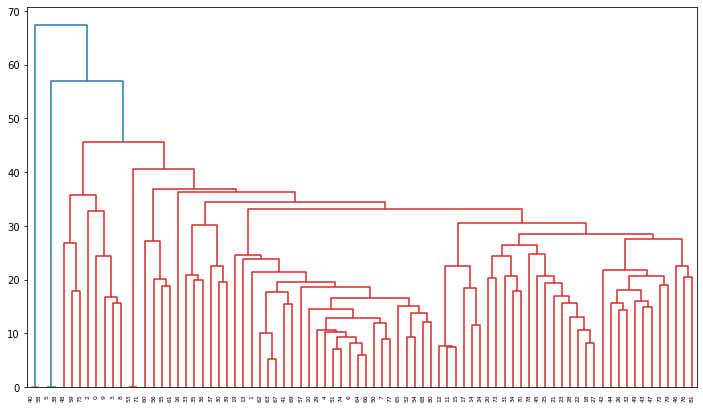

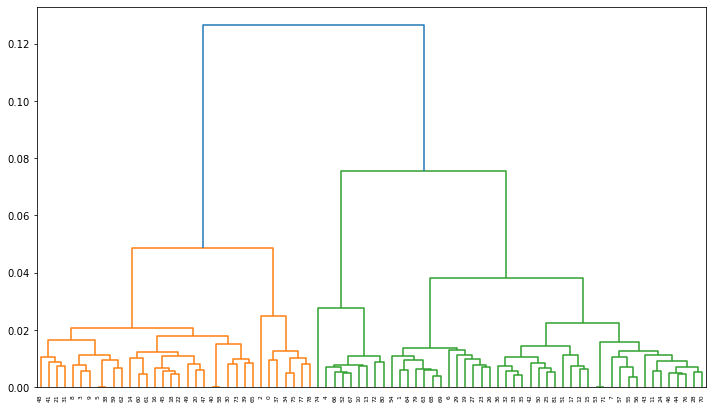

In [ ]:
# The appropriate number of clusters can be determined by looking at the different levels of merging in the dendrogram. 
# In a dendrogram, the tree can be cut by selecting a "height" that determines how many clusters the data will be divided into. 
# Often longer vertical lines in the dendrogram are chosen for cutting, as this indicates a greater variation between the clusters merged at this level.

# Hierarchical clustering on Count vectorized data
linked= linkage(X_cv_t, 'ward', metric= 'euclidean')
plt.figure(figsize=(12, 7))
dendrogram(linked)
plt.show()

# Hierarchical clustering on word embedding data
linked1= linkage(X_we_t, 'ward', metric= 'euclidean')
plt.figure(figsize=(12, 7))
dendrogram(linked1)
plt.show()

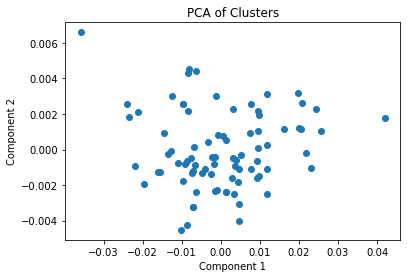

In [ ]:
#Create a visualisation of the clustering results using a dimensionality reduction technique PCA.
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embeddings)

plt.scatter(reduced_data[:,0], reduced_data[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA of Clusters')
plt.show()

In [7]:
#Step 5 Output Generation:

In [7]:
# Using labels got from KMeans clustering on word embedding dataset
labels= we_codes.ravel()
df_new= df.merge(pd.Series(labels, name='label'), left_index= True, right_index=True)
df_new.head(5)
df_new.to_csv('labeled_papers.csv', index=False)
print(df_new['label'].value_counts())

# word cloud function
def word_cloud(data):
  corpus= ' '.join(data)
  stopwords= set(STOPWORDS)
  return(WordCloud(stopwords= stopwords, max_words= 100, background_color= 'white').generate(corpus))

# Plotting word cloud for all 2 labels
fig, axs= plt.subplots(1, 2, figsize=(22, 10))
for i in range(2):
  data= df_new[df_new.label== i]['processed_abstract']
  wc= word_cloud(data)
  axs[i].imshow(wc)
  axs[i].set_title(f'Word Cloud for label {i}')
plt.show()

1    43
0    39
Name: label, dtype: int64


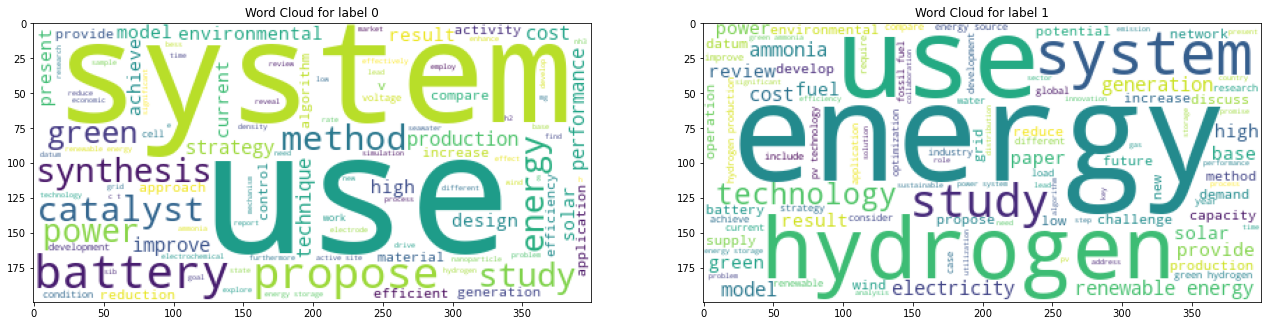

In [7]:
#Save and print the clustering results

In [8]:
#According to the keywords showed in the word cloud 
#The label 0 has 39 papers that with topic of biologic， while the label 1 has 43 papers with topic of chemotherapy